<a href="https://colab.research.google.com/github/VMBoehm/N3ASProject_Annie/blob/main/notebooks/ContrastiveLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contrastive Learning Code

In [1]:
!pip install git+https://github.com/VMBoehm/PytorchPAE.git@4Annie

  Cloning https://github.com/VMBoehm/PytorchPAE.git (to revision 4Annie) to /tmp/pip-req-build-srslgf4r
  Running command git clone -q https://github.com/VMBoehm/PytorchPAE.git /tmp/pip-req-build-srslgf4r
  Running command git checkout -b 4Annie --track origin/4Annie
  Switched to a new branch '4Annie'
  Branch '4Annie' set up to track remote branch '4Annie' from 'origin'.
  Created wheel for pytorch-pae: filename=pytorch_pae-0.1.dev17+g982644b-py3-none-any.whl size=14107 sha256=1bfae7f5a801c2e5fce15af5a7be2105996312a5dddc8a22b9dd95052a557ba9
  Stored in directory: /tmp/pip-ephem-wheel-cache-5y0v9536/wheels/78/cc/78/d3a54eac541cbd419347e36d065b35fb9a9740d1a9507e2b60
Successfully built pytorch-pae
  Attempting uninstall: pytorch-pae
    Found existing installation: pytorch-pae 0.1.dev16+gb965226
    Uninstalling pytorch-pae-0.1.dev16+gb965226:
      Successfully uninstalled pytorch-pae-0.1.dev16+gb965226


In [2]:
# import this package 
from pytorch_pae import AE
from pytorch_pae import custom_transforms as ct

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
# import pytorch
import torch
print(torch.__version__)

1.10.0+cu111


In [5]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
from torchsummary import summary
from torchvision import transforms

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
tt = transforms.Compose(
    [
        ct.RandomMask(masked_frac=0.4)
    ]
)
tt = ct.ContrastiveTransformations(tt)

## Step 1: Choose your parameters

In [9]:
SEED          = 287505

## data parameters
dataset       = 'SDSS_DR16_corrupted'
loc           = 'drive/MyDrive/ML_lecture_data/'
# number of layers in networks
n_layers     = 1

## fully connected net specific parameters
# output size of each fully connected layer
out_sizes    = [256]

## parameters that apply to both, fully connected and convolutional nets 
# dropout rate after each layer
dropout_rate = [0.0]
# whether to Lipschitz regularize by bounding the spectral norm 
spec_norm    = False
# activation function after each layer
activations  = ['ReLU']
# whether to add a bias in each layer or not
bias         = [True]
# whether tp apply a layer normalization after conv layer
layer_norm   = [False]
# whether to train elemntwise affine parameters for normalization layer 
affine       = False

## general parameters
# data dimensionality
dim          = '1D'
# latent space dimensionality
latent_dim   = 8
hidden_dim   = 4
# number of channels in data
input_c      = 1 
# data dimensioality along one axis (only square data supported in 2D)
input_dim    = 1000
# type of encoder and decoder network (either 'fc' or 'conv')
encoder_type = 'fc'
decoder_type = 'fc'

# if True, the output is fed through a sigmoid layer to bring data values into range [0,1]
final_sigmoid = False


## Training parameters
nepochs          = 20
batchsize        = 64
batchsize_valid  = 64
initial_lr       = 1e-2

optimizer        = 'Adam'
criterion1       = 'contrastive_loss'
criterion2       = 'contrastive_loss'

scheduler        = 'ExponentialLR'
scheduler_params = {'gamma':0.98}
ann_epoch        = 500

contrastive      = True
tau              = 0.05

In [10]:
general_params      = {'input_c': input_c, 'input_dim': input_dim, 'latent_dim': latent_dim, 'encoder_type': encoder_type, 'decoder_type': decoder_type, 'dim': dim, 'contrastive':contrastive, 'hidden_dim':hidden_dim, 'tau': tau}
fc_network_params   = {'n_layers': n_layers, 'out_sizes': out_sizes,'activations': activations, 'spec_norm': spec_norm, 'dropout_rate':dropout_rate, \
                       'layer_norm': layer_norm, 'affine': affine, 'final_sigmoid': final_sigmoid, 'bias':bias}
training_params     = {'batchsize': batchsize, 'initial_lr': initial_lr, 'optimizer': optimizer, 'criterion1': criterion1, 'criterion2': criterion2,
                       'scheduler': scheduler, 'scheduler_params':scheduler_params, 'ann_epoch': ann_epoch, 'batchsize_valid': batchsize_valid}
data_params         = {'dataset':dataset, 'loc': loc}

In [11]:
torch.manual_seed(SEED)
np.random.seed(SEED)

## Step 2: Set up and train the autoencoder

In [12]:
AE1 = AE.Autoencoder(general_params,data_params,fc_network_params, fc_network_params, training_params, device, tt)

(100000, 1000, 1) 100000
(100000, 1, 1000)
(30000, 1000, 1) 30000
(30000, 1, 1000)


In [13]:
len(AE1.train_loader)*batchsize

100032

In [14]:
if dim =='1D':
    summary(AE1, (input_c,input_dim))
else:
    summary(AE1, (input_c, input_dim, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 1000]               0
            Linear-2                  [-1, 256]         256,256
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                    [-1, 8]           2,056
         FCEncoder-6                    [-1, 8]               0
              ReLU-7                    [-1, 8]               0
            Linear-8                    [-1, 6]              54
              ReLU-9                    [-1, 6]               0
           Linear-10                    [-1, 4]              28
Total params: 258,394
Trainable params: 258,394
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.99
Estimated T

In [15]:
train_loss, valid_loss = AE1.train(nepochs)

epoch: 0, training loss: 2.0148e+00, validation loss: 1.7586e+00, learning rate: 9.8000e-03
epoch: 1, training loss: 1.6145e+00, validation loss: 1.6328e+00, learning rate: 9.6040e-03
epoch: 2, training loss: 1.5428e+00, validation loss: 1.4332e+00, learning rate: 9.4119e-03
epoch: 3, training loss: 1.5117e+00, validation loss: 1.7265e+00, learning rate: 9.2237e-03
epoch: 4, training loss: 1.4818e+00, validation loss: 1.5238e+00, learning rate: 9.0392e-03
epoch: 5, training loss: 1.4716e+00, validation loss: 1.3856e+00, learning rate: 8.8584e-03
epoch: 6, training loss: 1.4586e+00, validation loss: 1.5286e+00, learning rate: 8.6813e-03
epoch: 7, training loss: 1.4444e+00, validation loss: 1.3155e+00, learning rate: 8.5076e-03
epoch: 8, training loss: 1.4393e+00, validation loss: 1.5529e+00, learning rate: 8.3375e-03
epoch: 9, training loss: 1.4368e+00, validation loss: 1.3387e+00, learning rate: 8.1707e-03
epoch: 10, training loss: 1.4220e+00, validation loss: 1.2560e+00, learning rate

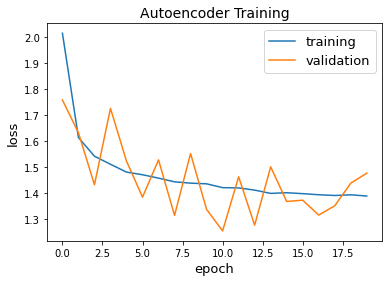

In [16]:
plt.figure()
plt.title('Contrastive Learning Training',fontsize=14)
plt.plot(train_loss, label='training')
plt.plot(valid_loss, label='validation')
plt.xlabel('epoch',fontsize=13)
plt.ylabel('loss',fontsize=13)
plt.legend(fontsize=13)
plt.show()